# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch14/ch14_part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크

check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:

In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

--2023-08-19 06:35:20--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1629 (1.6K) [text/plain]
Saving to: ‘python_environment_check.py’

python_environment_ 100%[===================>]   1.59K  --.-KB/s    in 0s      

2023-08-19 06:35:21 (7.12 MB/s) - ‘python_environment_check.py’ saved [1629/1629]



권장 패키지 버전을 확인하세요:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'torch': '1.8.0',
    'torchvision': '0.9.0'
}
check_packages(d)

[OK] Your Python version is 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
[OK] numpy 1.23.5
[OK] scipy 1.10.1
[OK] matplotlib 3.7.1
[OK] torch 2.0.1+cu118
[OK] torchvision 0.15.2+cu118


# 14장 - 심층 합성곱 신경망으로 이미지 분류 (파트 1/2)

**목차**

- 합성곱 신경망의 구성 요소
  - CNN과 특성 계층 학습
  - 이산 합성곱 수행
    - 1차원 이산 합성곱 연산 수행
    - 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기
    - 합성곱 출력 크기 계산
    - 2D 이산 합성곱 수행
  - 서브샘플링
- 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성
  - 여러 개의 입력 또는 컬러 채널 다루기
  - L2 규제와 드롭아웃으로 신경망 규제
  - 분류를 위한 손실 함수
- 파이토치를 사용하여 심층 합성곱 신경망 구현
  - 다층 CNN 구조
  - 데이터 적재와 전처리
  - `torch.nn` 모듈을 사용하여 CNN 구현
    - 파이토치에서 CNN 층 구성하기
    - 파이토치로 CNN 구성하기

In [3]:
from IPython.display import Image
%matplotlib inline

##  합성곱 신경망의 구성 요소

### CNN과 특성 계층 학습

In [4]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_01.png', width=700)

### 이산 합성곱 수행

#### 1차원 이산 합성곱 연산 수행

In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_02.png', width=700)

In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_03.png', width=700)

#### 출력 특성 맵의 크기를 조절하기 위해 입력에 패딩하기

In [7]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_04.png', width=700)

#### 합성곱 출력 크기 계산

In [8]:
import torch
import numpy as np

In [9]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## 테스트:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d 구현:',
      conv1d(x, w, p=2, s=1))

print('넘파이 결과:',
      np.convolve(x, w, mode='same'))

Conv1d 구현: [ 5. 14. 16. 26. 24. 34. 19. 22.]
넘파이 결과: [ 5 14 16 26 24 34 19 22]


#### 2D 이산 합성곱 수행

In [10]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_05.png', width=700)

In [11]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_06.png', width=600)

In [12]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_07.png', width=800)

In [13]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] -
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] -
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d 구현:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))

print('사이파이 결과:\n',
    scipy.signal.convolve2d(X, W, mode='same'))

Conv2d 구현:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
사이파이 결과:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


### 서브샘플링

In [14]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_08.png', width=700)

## 기본 구성 요소를 사용하여 심층 합성곱 신경망 구성

### 여러 개의 입력 또는 컬러 채널 다루기

In [15]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_09.png', width=800)

**팁: 이미지 파일 읽기**

In [17]:
# 코랩의 경우 깃허브 저장소로부터 example-image.png를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/example-image.png

--2023-08-19 06:36:35--  https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/example-image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22283 (22K) [image/png]
Saving to: ‘example-image.png’

example-image.png   100%[===================>]  21.76K  --.-KB/s    in 0s      

2023-08-19 06:36:35 (138 MB/s) - ‘example-image.png’ saved [22283/22283]



In [18]:
import torch
from torchvision.io import read_image

img = read_image('example-image.png')

print('이미지 크기:', img.shape)
print('채널 개수:', img.shape[0])
print('이미지 데이터 타입:', img.dtype)
print(img[:, 100:102, 100:102])

이미지 크기: torch.Size([3, 252, 221])
채널 개수: 3
이미지 데이터 타입: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


### L2 규제와 드롭아웃으로 신경망 규제

In [19]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_10.png', width=700)

In [20]:
import torch.nn as nn
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

### 분류를 위한 손실 함수

 * **`nn.BCELoss()`**
   * `from_logits=False`
   * `from_logits=True`

 * **`nn.CrossEntropyLoss()`**
   * `from_logits=False`
   * `from_logits=True`

In [22]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_11.png', width=800)

In [23]:
####### 이진 크로스 엔트로피
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (확률): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (로짓): {bce_logits_loss_fn(logits, target):.4f}')


####### 범주형 크로스 엔트로피
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (로짓): {cce_logits_loss_fn(logits, target):.4f}')
print(f'CCE (확률): {cce_loss_fn(torch.log(probas), target):.4f}')

BCE (확률): 0.3711
BCE (로짓): 0.3711
CCE (로짓): 0.5996
CCE (확률): 0.5996


## 파이토치를 사용하여 심층 합성곱 신경망 구현

### 다층 CNN 구조

In [24]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch14/figures/14_12.png', width=800)

### 데이터 적재와 전처리

In [25]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 501540620.11it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41727762.25it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 163538778.33it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5887060.81it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [26]:
from torch.utils.data import DataLoader


batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### `torch.nn` 모듈을 사용하여 CNN 구현

#### 파이토치에서 CNN 층 구성하기

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

#### 파이토치로 CNN 구성하기

In [27]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [28]:
model.add_module('flatten', nn.Flatten())

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [29]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'에포크 {epoch+1} 정확도: {accuracy_hist_train[epoch]:.4f} 검증 정확도: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

에포크 1 정확도: 0.9500 검증 정확도: 0.9818
에포크 2 정확도: 0.9840 검증 정확도: 0.9858
에포크 3 정확도: 0.9891 검증 정확도: 0.9839
에포크 4 정확도: 0.9921 검증 정확도: 0.9898
에포크 5 정확도: 0.9934 검증 정확도: 0.9896
에포크 6 정확도: 0.9947 검증 정확도: 0.9883
에포크 7 정확도: 0.9955 검증 정확도: 0.9904
에포크 8 정확도: 0.9958 검증 정확도: 0.9884
에포크 9 정확도: 0.9963 검증 정확도: 0.9900
에포크 10 정확도: 0.9972 검증 정확도: 0.9908
에포크 11 정확도: 0.9971 검증 정확도: 0.9888
에포크 12 정확도: 0.9975 검증 정확도: 0.9897
에포크 13 정확도: 0.9975 검증 정확도: 0.9903
에포크 14 정확도: 0.9977 검증 정확도: 0.9906
에포크 15 정확도: 0.9978 검증 정확도: 0.9890
에포크 16 정확도: 0.9977 검증 정확도: 0.9911
에포크 17 정확도: 0.9981 검증 정확도: 0.9903
에포크 18 정확도: 0.9982 검증 정확도: 0.9892
에포크 19 정확도: 0.9980 검증 정확도: 0.9899
에포크 20 정확도: 0.9987 검증 정확도: 0.9894


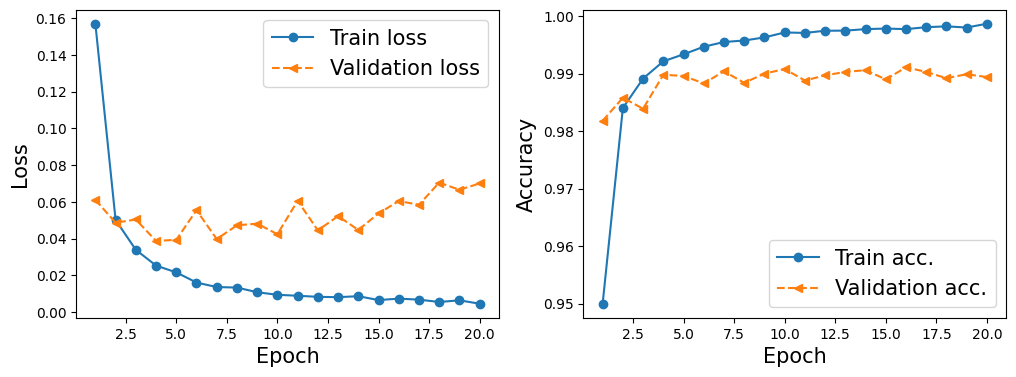

In [32]:
import matplotlib.pyplot as plt


x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

#plt.savefig('figures/14_13.png')
plt.show()

In [33]:
torch.cuda.synchronize()
model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'테스트 정확도: {is_correct.mean():.4f}')

테스트 정확도: 0.9942


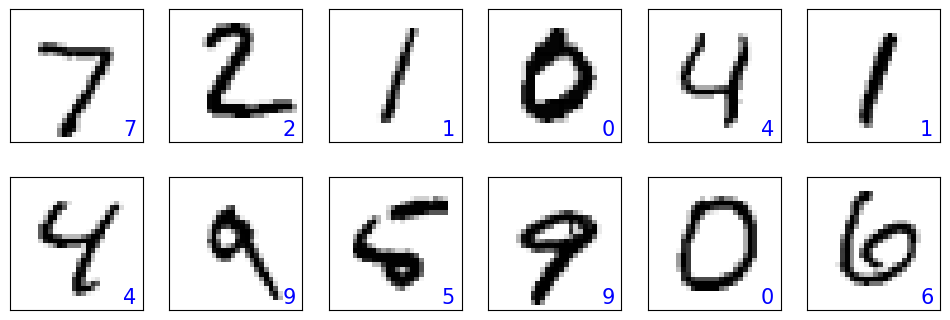

In [34]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)


#plt.savefig('figures/14_14.png')
plt.show()

In [35]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)